connexion avec sql manager server studio

In [6]:
import pyodbc
import pandas as pd

# Paramètres de connexion
server = 'DESKTOP-0G2RAEB'         # Nom du serveur
database = 'DW_SAP_Co2'           # Remplace par le nom réel de ta base

try:
    # Tentative de connexion
    conn = pyodbc.connect(
        f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}',
        timeout=5  # Timeout après 5 secondes si la connexion échoue
    )
    
    # Exécution d'une requête simple pour tester la connexion
    cursor = conn.cursor()
    cursor.execute("SELECT TOP 1 * FROM Fact_MM_PM")  # Assurez-vous que cette table existe
    row = cursor.fetchone()
    
    # Vérification de la réponse
    if row:
        print("Connexion réussie! Voici une ligne de données : ", row)
    else:
        print("Connexion réussie mais pas de données retournées.")
    
    # Fermeture de la connexion
    cursor.close()
    conn.close()

except pyodbc.Error as e:
    print("Erreur lors de la connexion à SQL Server:", e)

Connexion réussie! Voici une ligne de données :  (24, 430, 3, 649, 509, 3, 1, 1, 593.0, 49, 6, 4, '4')


# xgBoost

C:\Users\MSI\AppData\Local\Temp\ipykernel_3148\457413047.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)
C:\Users\MSI\ansel\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:47:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🎯 Seuil optimal F1 = 0.01
🔢 F1-score maximal = 0.960

📋 Rapport de classification (seuil optimisé) :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       166
           1       1.00      0.92      0.96        13

    accuracy                           0.99       179
   macro avg       1.00      0.96      0.98       179
weighted avg       0.99      0.99      0.99       179



C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


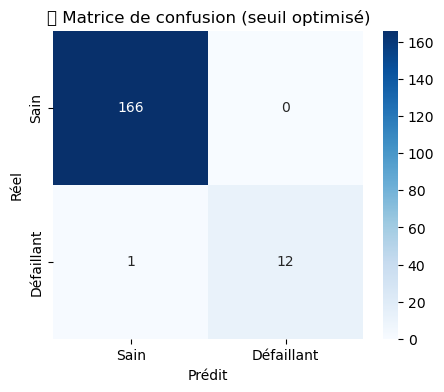

C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


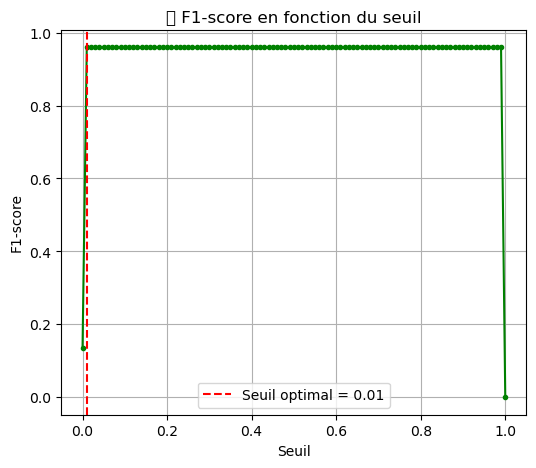


⚠️ Top 10 équipements les plus à risque :
    Equipment_ID  Risque_De_Defaillance_%
461        E4873                 99.84993
852        E9578                 99.84993
173        E1517                 99.84993
533        E5535                 99.84993
602        E6464                 99.84993
183        E1629                 99.84993
814        E9012                 99.84993
714        E7906                 99.84993
710        E7812                 99.84993
293        E2996                 99.84993
🔢 Total équipements : 894
⚙️ Équipements avec panne : 63
🧪 Pannes dans le jeu de test : 13
✅ Fichier 'predictions_equipements.csv' exporté avec succès !


In [4]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# 1️⃣ Connexion SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

query = """
SELECT 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years,
    MAX(f.Fk_Material) AS Fk_Material,
    MAX(f.Fk_Location) AS Fk_Location,
    MAX(f.Fk_usine) AS Fk_usine,
    COUNT(f.Fk_Equipment) AS Nb_Defaillances
FROM Dim_Equipment e
LEFT JOIN Fact_MM_PM f ON f.Fk_Equipment = e.Pk_Equipment
GROUP BY 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years
"""
data = pd.read_sql(query, conn)
conn.close()

# 2️⃣ Cible binaire
data['High_Risk'] = (data['Nb_Defaillances'] > 0).astype(int)

# 3️⃣ Encodage
data['Manufacturer'] = LabelEncoder().fit_transform(data['Manufacturer'])

# 4️⃣ Encodage one-hot pour variables catégorielles
data = pd.get_dummies(data, columns=[
    'Fk_Category', 'Fk_Energy', 'Fk_Mfrequency', 'Fk_MCycle',
    'Fk_Material', 'Fk_Location', 'Fk_usine'
])

# 5️⃣ X et y
X = data.drop(columns=['High_Risk', 'Equipment_ID', 'Equipment_Name', 'Nb_Defaillances'])
y = data['High_Risk']

# 6️⃣ Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7️⃣ SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 8️⃣ Entraînement XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_resampled, y_resampled)

# 9️⃣ Prédictions proba
y_scores = model.predict_proba(X_test)[:, 1]

# 🔟 🔁 Optimisation automatique du seuil
best_f1 = 0
best_thresh = 0
f1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

for thresh in thresholds:
    y_pred_temp = (y_scores > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"🎯 Seuil optimal F1 = {best_thresh:.2f}")
print(f"🔢 F1-score maximal = {best_f1:.3f}")

# 🔁 Prédiction finale avec seuil optimal
y_pred_optimal = (y_scores > best_thresh).astype(int)

# 🧾 Rapport de classification
print("\n📋 Rapport de classification (seuil optimisé) :")
print(classification_report(y_test, y_pred_optimal))

# 📦 Matrice de confusion
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sain', 'Défaillant'], yticklabels=['Sain', 'Défaillant'])
plt.title("📦 Matrice de confusion (seuil optimisé)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# 📈 Courbe F1-score vs Seuil
plt.figure(figsize=(6,5))
plt.plot(thresholds, f1_scores, color='green', marker='.')
plt.axvline(best_thresh, linestyle='--', color='red', label=f"Seuil optimal = {best_thresh:.2f}")
plt.title("📈 F1-score en fonction du seuil")
plt.xlabel("Seuil")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.show()

# 🔮 Risque prédictif sur tout le dataset
data['Risque_De_Defaillance_%'] = model.predict_proba(X)[:, 1] * 100
top_risque = data[['Equipment_ID', 'Risque_De_Defaillance_%']].sort_values(by='Risque_De_Defaillance_%', ascending=False)
print("\n⚠️ Top 10 équipements les plus à risque :")
print(top_risque.head(10))

# 📊 Statistiques
print("🔢 Total équipements :", len(data))
print("⚙️ Équipements avec panne :", data['High_Risk'].sum())
print("🧪 Pannes dans le jeu de test :", y_test.sum())
# ✅ Appliquer le seuil optimal sur toutes les données
all_scores = model.predict_proba(X)[:, 1]
data['Risque_De_Defaillance_%'] = all_scores * 100
data['Prediction_Binaire'] = (all_scores > best_thresh).astype(int)

# 📝 Sélectionner les colonnes à exporter
export_df = data[['Equipment_ID', 'Risque_De_Defaillance_%', 'Prediction_Binaire']]

# 💾 Export vers CSV
export_df.to_csv("predictions_equipements.csv", index=False, encoding='utf-8-sig')

print("✅ Fichier 'predictions_equipements.csv' exporté avec succès !")



# Naive Bayes

C:\Users\MSI\AppData\Local\Temp\ipykernel_3148\1095320681.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


🎯 Seuil optimal F1 = 0.00
🔢 F1-score maximal = 1.000

📋 Rapport de classification (seuil optimisé) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        13

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


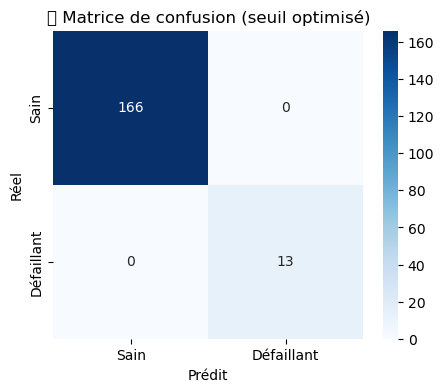

C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


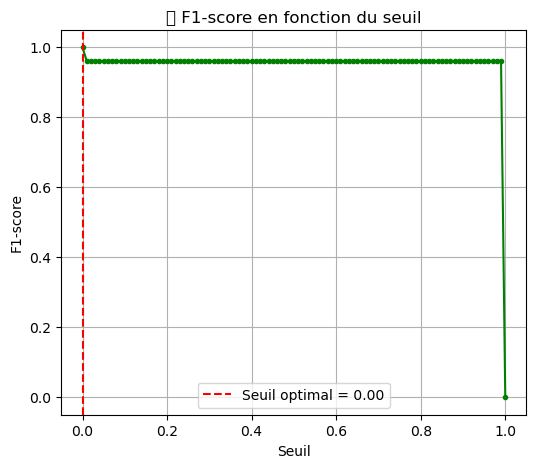

✅ Fichier 'predictions_equipements_naive_bayes.csv' exporté avec succès !


In [5]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# 1️⃣ Connexion SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

query = """
SELECT 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years,
    MAX(f.Fk_Material) AS Fk_Material,
    MAX(f.Fk_Location) AS Fk_Location,
    MAX(f.Fk_usine) AS Fk_usine,
    COUNT(f.Fk_Equipment) AS Nb_Defaillances
FROM Dim_Equipment e
LEFT JOIN Fact_MM_PM f ON f.Fk_Equipment = e.Pk_Equipment
GROUP BY 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years
"""
data = pd.read_sql(query, conn)
conn.close()

# 2️⃣ Cible binaire
data['High_Risk'] = (data['Nb_Defaillances'] > 0).astype(int)

# 3️⃣ Encodage
data['Manufacturer'] = LabelEncoder().fit_transform(data['Manufacturer'])

# 4️⃣ Encodage one-hot
data = pd.get_dummies(data, columns=[
    'Fk_Category', 'Fk_Energy', 'Fk_Mfrequency', 'Fk_MCycle',
    'Fk_Material', 'Fk_Location', 'Fk_usine'
])

# 5️⃣ X et y
X = data.drop(columns=['High_Risk', 'Equipment_ID', 'Equipment_Name', 'Nb_Defaillances'])
y = data['High_Risk']

# 6️⃣ Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7️⃣ SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 8️⃣ Naive Bayes
model = GaussianNB()
model.fit(X_resampled, y_resampled)

# 9️⃣ Probabilités
y_scores = model.predict_proba(X_test)[:, 1]

# 🔟 Seuil optimal
best_f1 = 0
best_thresh = 0
f1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

for thresh in thresholds:
    y_pred_temp = (y_scores > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"🎯 Seuil optimal F1 = {best_thresh:.2f}")
print(f"🔢 F1-score maximal = {best_f1:.3f}")

# ✅ Prédiction finale avec seuil optimal
y_pred_optimal = (y_scores > best_thresh).astype(int)

# 🧾 Rapport de classification
print("\n📋 Rapport de classification (seuil optimisé) :")
print(classification_report(y_test, y_pred_optimal))

# 📦 Matrice de confusion
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sain', 'Défaillant'], yticklabels=['Sain', 'Défaillant'])
plt.title("📦 Matrice de confusion (seuil optimisé)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# 📈 F1 vs Seuil
plt.figure(figsize=(6,5))
plt.plot(thresholds, f1_scores, color='green', marker='.')
plt.axvline(best_thresh, linestyle='--', color='red', label=f"Seuil optimal = {best_thresh:.2f}")
plt.title("📈 F1-score en fonction du seuil")
plt.xlabel("Seuil")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.show()

# 🔮 Risque prédictif pour tous les équipements
all_scores = model.predict_proba(X)[:, 1]
data['Risque_De_Defaillance_%'] = all_scores * 100
data['Prediction_Binaire'] = (all_scores > best_thresh).astype(int)

# 💾 Export CSV
export_df = data[['Equipment_ID', 'Risque_De_Defaillance_%', 'Prediction_Binaire']]
export_df.to_csv("predictions_equipements_naive_bayes.csv", index=False, encoding='utf-8-sig')

print("✅ Fichier 'predictions_equipements_naive_bayes.csv' exporté avec succès !")


# decision tree

C:\Users\MSI\AppData\Local\Temp\ipykernel_3148\1706197490.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)
C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


🎯 Seuil optimal F1 = 0.00
🔢 F1-score maximal = 0.960

📋 Rapport de classification (seuil optimisé) :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       166
           1       1.00      0.92      0.96        13

    accuracy                           0.99       179
   macro avg       1.00      0.96      0.98       179
weighted avg       0.99      0.99      0.99       179



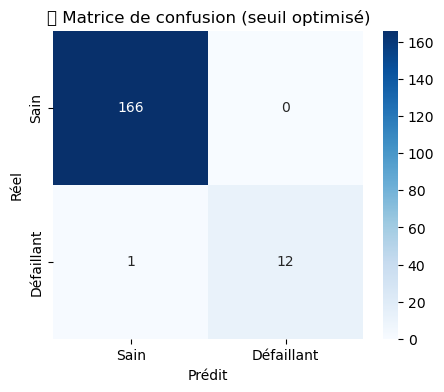

C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


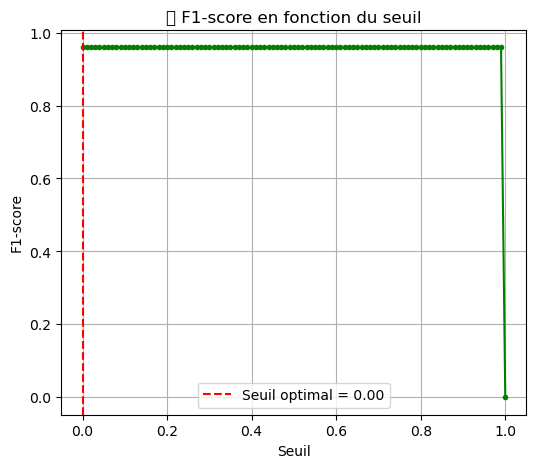

✅ Fichier 'predictions_equipements_decision_tree.csv' exporté avec succès !


In [6]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# 1️⃣ Connexion SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

query = """
SELECT 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years,
    MAX(f.Fk_Material) AS Fk_Material,
    MAX(f.Fk_Location) AS Fk_Location,
    MAX(f.Fk_usine) AS Fk_usine,
    COUNT(f.Fk_Equipment) AS Nb_Defaillances
FROM Dim_Equipment e
LEFT JOIN Fact_MM_PM f ON f.Fk_Equipment = e.Pk_Equipment
GROUP BY 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years
"""
data = pd.read_sql(query, conn)
conn.close()

# 2️⃣ Cible binaire
data['High_Risk'] = (data['Nb_Defaillances'] > 0).astype(int)

# 3️⃣ Encodage
data['Manufacturer'] = LabelEncoder().fit_transform(data['Manufacturer'])

# 4️⃣ Encodage one-hot
data = pd.get_dummies(data, columns=[
    'Fk_Category', 'Fk_Energy', 'Fk_Mfrequency', 'Fk_MCycle',
    'Fk_Material', 'Fk_Location', 'Fk_usine'
])

# 5️⃣ Définir X et y
X = data.drop(columns=['High_Risk', 'Equipment_ID', 'Equipment_Name', 'Nb_Defaillances'])
y = data['High_Risk']

# 6️⃣ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7️⃣ SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 8️⃣ Entraînement Decision Tree
model = DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(X_resampled, y_resampled)

# 9️⃣ Prédictions proba
y_scores = model.predict_proba(X_test)[:, 1]

# 🔟 🔁 Optimisation du seuil F1
best_f1 = 0
best_thresh = 0
f1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

for thresh in thresholds:
    y_pred_temp = (y_scores > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"🎯 Seuil optimal F1 = {best_thresh:.2f}")
print(f"🔢 F1-score maximal = {best_f1:.3f}")

# 🔁 Prédiction finale avec seuil optimal
y_pred_optimal = (y_scores > best_thresh).astype(int)

# 🧾 Rapport de classification
print("\n📋 Rapport de classification (seuil optimisé) :")
print(classification_report(y_test, y_pred_optimal))

# 📦 Matrice de confusion
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sain', 'Défaillant'], yticklabels=['Sain', 'Défaillant'])
plt.title("📦 Matrice de confusion (seuil optimisé)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# 📈 Courbe F1-score vs Seuil
plt.figure(figsize=(6,5))
plt.plot(thresholds, f1_scores, color='green', marker='.')
plt.axvline(best_thresh, linestyle='--', color='red', label=f"Seuil optimal = {best_thresh:.2f}")
plt.title("📈 F1-score en fonction du seuil")
plt.xlabel("Seuil")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.show()

# 🔮 Risque prédictif sur tout le dataset
all_scores = model.predict_proba(X)[:, 1]
data['Risque_De_Defaillance_%'] = all_scores * 100
data['Prediction_Binaire'] = (all_scores > best_thresh).astype(int)

# 📤 Export CSV
export_df = data[['Equipment_ID', 'Risque_De_Defaillance_%', 'Prediction_Binaire']]
export_df.to_csv("predictions_equipements_decision_tree.csv", index=False, encoding='utf-8-sig')

print("✅ Fichier 'predictions_equipements_decision_tree.csv' exporté avec succès !")


# comparaison

C:\Users\MSI\AppData\Local\Temp\ipykernel_21332\2742228049.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)
C:\Users\MSI\ansel\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Résultats pour XGBoost
Seuil optimal F1 = 0.01
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       166
           1       1.00      0.92      0.96        13

    accuracy                           0.99       179
   macro avg       1.00      0.96      0.98       179
weighted avg       0.99      0.99      0.99       179


📊 Résultats pour Decision Tree
Seuil optimal F1 = 0.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       166
           1       1.00      0.92      0.96        13

    accuracy                           0.99       179
   macro avg       1.00      0.96      0.98       179
weighted avg       0.99      0.99      0.99       179


📊 Résultats pour Naive Bayes
Seuil optimal F1 = 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        13

    accuracy          

C:\Users\MSI\AppData\Local\Temp\ipykernel_21332\2742228049.py:123: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


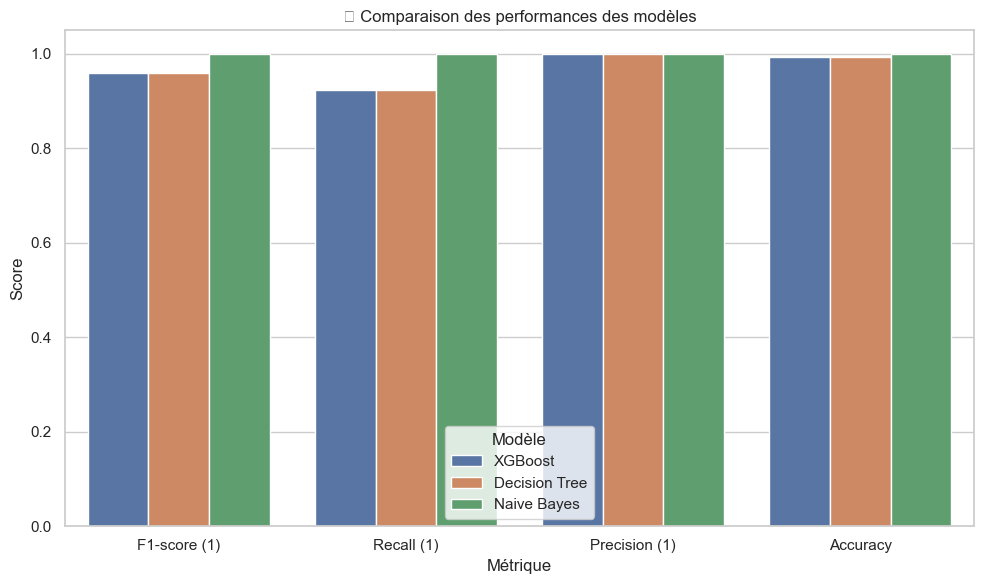

In [2]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt


# 1️⃣ Connexion à la base SQL
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

query = """
SELECT 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years,
    MAX(f.Fk_Material) AS Fk_Material,
    MAX(f.Fk_Location) AS Fk_Location,
    MAX(f.Fk_usine) AS Fk_usine,
    COUNT(f.Fk_Equipment) AS Nb_Defaillances
FROM Dim_Equipment e
LEFT JOIN Fact_MM_PM f ON f.Fk_Equipment = e.Pk_Equipment
GROUP BY 
    e.Equipment_ID,
    e.Equipment_Name,
    e.Fk_Category,
    e.Fk_Energy,
    e.Fk_Mfrequency,
    e.Fk_MCycle,
    e.Manufacturer,
    e.Estimated_Lifetime_Years
"""
data = pd.read_sql(query, conn)
conn.close()

# 2️⃣ Préparation des données
data['High_Risk'] = (data['Nb_Defaillances'] > 0).astype(int)
data['Manufacturer'] = LabelEncoder().fit_transform(data['Manufacturer'])
data = pd.get_dummies(data, columns=[
    'Fk_Category', 'Fk_Energy', 'Fk_Mfrequency', 'Fk_MCycle',
    'Fk_Material', 'Fk_Location', 'Fk_usine'
])
X = data.drop(columns=['High_Risk', 'Equipment_ID', 'Equipment_Name', 'Nb_Defaillances'])
y = data['High_Risk']

# 3️⃣ Split + SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 4️⃣ Fonction d'évaluation
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    best_f1 = 0
    best_thresh = 0
    thresholds = np.arange(0, 1.01, 0.01)
    for thresh in thresholds:
        y_pred = (y_scores > thresh).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    y_pred_final = (y_scores > best_thresh).astype(int)
    report = classification_report(y_test, y_pred_final, output_dict=True)

    print(f"\n📊 Résultats pour {name}")
    print(f"Seuil optimal F1 = {best_thresh:.2f}")
    print(classification_report(y_test, y_pred_final))

    return {
        "Modèle": name,
        "Seuil_F1": best_thresh,
        "Accuracy": accuracy_score(y_test, y_pred_final),
        "F1-score (1)": report['1']['f1-score'],
        "Recall (1)": report['1']['recall'],
        "Precision (1)": report['1']['precision']
    }

# 5️⃣ Évaluer les 3 modèles
models_results = []
models_results.append(evaluate_model("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X_resampled, y_resampled, X_test, y_test))
models_results.append(evaluate_model("Decision Tree", DecisionTreeClassifier(max_depth=5), X_resampled, y_resampled, X_test, y_test))
models_results.append(evaluate_model("Naive Bayes", GaussianNB(), X_resampled, y_resampled, X_test, y_test))

# 6️⃣ Tableau comparatif
results_df = pd.DataFrame(models_results)
print("\n📈 Comparatif final des modèles :")
print(results_df.sort_values(by="F1-score (1)", ascending=False))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# 💡 Sélection des métriques à comparer
metrics = ['F1-score (1)', 'Recall (1)', 'Precision (1)', 'Accuracy']
results_melted = results_df.melt(id_vars='Modèle', value_vars=metrics, var_name='Métrique', value_name='Valeur')

# 🎨 Création du barplot
sns.barplot(data=results_melted, x='Métrique', y='Valeur', hue='Modèle')

plt.title("📊 Comparaison des performances des modèles")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(title="Modèle")
plt.tight_layout()
plt.show()

